In [43]:
import pykrige #biblioteca de geoestadística
import pykrige.kriging_tools as kt #herramientas para exportar e importar archivos .asc con biblioteca PyKrige
from pykrige.ok import OrdinaryKriging #Kriging Ordinario con PyKrige
import pandas as pd #biblioteca de manipulación y análisis de datos
import numpy as np #biblioteca de funciones matemáticas
import matplotlib.pyplot as plt #biblioteca de generación de gráficos
plt.style.use('ggplot') #estilo para gráficos en matplotlib


In [44]:
import pandas as pd
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from KSVM import KSVC, KSVR

from sklearn.model_selection import train_test_split,KFold, cross_val_score,ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
import numpy as np
from time import time
from multiprocessing.pool import Pool
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib.colors import LinearSegmentedColormap

In [95]:
dff=pd.read_csv('modis_model.csv')        
nr=dff.shape[1]
Xl=dff.iloc[:,0:nr-1]
yl=dff.iloc[:,nr-1:nr]    
yl=yl.values.ravel()
print(Xl.shape, yl.shape)
dff.head()

(445, 9) (445,)


,latitude,longitude,band1,band2,band3,band4,band5,band6,band7,value
0,-8789850.0,184950.0,3296.903053,4486.123350,3395.320132,3448.007013,4321.515264,3236.024752,2072.205033,203.4
1,-8784900.0,174600.0,2723.544879,3882.381574,2847.123764,2902.167260,3775.932780,2743.972716,1732.732701,198.3
2,-8775000.0,169650.0,3254.548374,4358.613821,3360.056504,3400.073577,4235.783333,3224.044715,2056.696341,199.1
3,-8775000.0,174600.0,3180.592105,4523.587582,3305.417352,3344.582237,4318.231908,3244.020970,2032.567434,196.3
4,-8775000.0,184950.0,3307.844581,4718.300204,3427.576687,3472.932106,4445.462986,3319.962372,2059.508384,196.9


In [46]:
def normalizerTransform(x,nm):       
    if(nm=="Min_Max"):#mix-max
        scaler=MinMaxScaler()
        scaler.fit(x)
        return scaler.transform(x)
    if(nm=="Normalizer"):#normalizer
        scaler=Normalizer()
        scaler.fit(x)
        return scaler.transform(x)
    
    if(nm=="Standard"):#standard
        scaler=StandardScaler()
        scaler.fit(x)
        return scaler.transform(x)    
    return x

In [97]:
#Xnl=normalizerTransform(Xl,'Standard')
Xnl=normalizerTransform(Xl,'Min_Max')
#kernel= 'rquadratic', coef0= 0.1, C= 100.0
#C=10000.,gamma=100.,kernel='triangle'
#clfl=KSVR(kernel= 'triangle', gamma= 100.0, C= 1000.0)
clfl=KSVR(kernel= 'rquadratic', coef0= 0.1, C= 1000.0)
Xfl, Xtl, yfl, ytl = train_test_split(Xnl, yl, test_size=1/3,random_state=2578964)
clfl.fit(Xfl,yfl)
stl=clfl.score(Xtl,ytl)
sfl=clfl.score(Xfl,yfl)
sal=clfl.score(Xnl,yl)
print(stl,sfl,sal)

0.8638536927318892 0.9998356202927176 0.9572596783106366


In [98]:
x=np.array(dff['latitude'].tolist())
y=np.array(dff['longitude'].tolist())
z=clfl.predict(Xnl)
#z=np.array(dff['value'].tolist())

In [49]:
def show_map(x,y,z, clf, distance, resolution=450):

    np.random.seed(19680801)
    npts = x.shape[0]
    ngridx = resolution
    ngridy = resolution
  
    x_min=x.min()
    x_max=x.max()
    y_min=y.min()
    y_max=y.max()
    xi = np.linspace(x_min,x_max, ngridx)
    yi = np.linspace(y_min,y_max, ngridy)   
   
    Xi, Yi = np.meshgrid(xi, yi)
    Xi=Xi.ravel()
    Yi=Yi.ravel()
    
    xt=np.array([x,y]).T    
    
    Xt=np.array([Xi,Yi]).T
    print('xt',xt.shape)
    
    v_id=[]
    for i,xti in enumerate(Xt):
        dis=np.sum((xt-xti)**2, axis=1)**0.5
        #print(dis.min())
        if(dis.min()<=distance):
            v_id.append(i)
            #xt=xt.tolist()                   
            #xt.append(xti)                
            #xt=np.array(xt)
            #print('xt',xt.shape)


    print('Eliminados', len(v_id))

    print('antes')
    print(Xt.shape,Xi.shape, Yi.shape)
    Xt=Xt[v_id]
    Xi=Xi[v_id]
    Yi=Yi[v_id]


    print('despues')
    
    zi=clf.predict(Xt) 
    print(Xt.shape,Xi.shape, Yi.shape,zi.shape)
    
    
    colors = [(0, 0, 1), (0, 0.7, 0),(0, 1, 0),(0.9,1,0),(1,0.7,0),(1, 0.5, 0),(1, 0, 0) ]
    cmap_name = 'my_list'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    marker_size = 10
    
        
            
    plt.scatter(Xi, Yi, marker_size, zi, cmap=cm)
    
    plt.title("Radiación solar")
    cbar = plt.colorbar()
    cbar.set_label("W/m^2", labelpad=+1)
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    

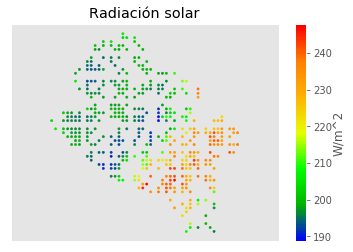

In [99]:
colors = [(0, 0, 1), (0, 0.7, 0),(0, 1, 0),(0.9,1,0),(1,0.7,0),(1, 0.5, 0),(1, 0, 0) ]
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
marker_size = 5
plt.scatter(x, y, marker_size, z, cmap=cm) #el estilo gist_rainbow es algo mas convencional.
plt.axis('equal')
plt.title("Radiación solar")
cbar = plt.colorbar()
cbar.set_label("W/m^2", labelpad=+1)
plt.xticks([])
plt.yticks([])
plt.show()

xt (445, 2)
Eliminados 457528
antes
(1000000, 2) (1000000,) (1000000,)
despues
(457528, 2) (457528,) (457528,) (457528,)


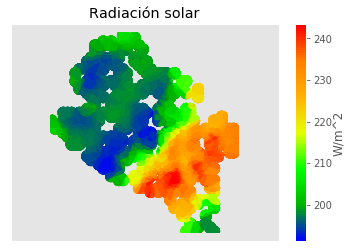

In [100]:
from sklearn.neighbors import KNeighborsRegressor
xt=dff.iloc[:,0:2]
yt=z

x_f, x_t, y_f,y_t=train_test_split(xt, yt, test_size=0.2)
neigh = KNeighborsRegressor(n_neighbors=4)
neigh.fit(x_f, y_f)
show_map(x,y,z,neigh, 6000,1000)


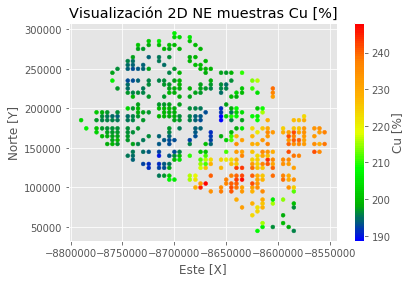

In [101]:
#variables convertidas a ndarray: Matriz Numpy

x = x
y = y
cu = z

#ploteo:
marker_size = 15
plt.scatter(x, y, marker_size, cu, cmap=cm) #el estilo gist_rainbow es algo mas convencional.
plt.xlabel("Este [X]")
plt.ylabel("Norte [Y]")
plt.title("Visualización 2D NE muestras Cu [%]")
cbar = plt.colorbar()
cbar.set_label("Cu [%]", labelpad=+1)

#plt.axis('equal')
plt.show()


In [102]:
print("std2: ",round(cu.var(), 2),"mean:",round(cu.mean(), 2),
      "max:",round(cu.max(), 2),"min:",round(cu.min(), 2)) #Referencia para el variograma.


std2:  289.92 mean: 210.09 max: 248.0 min: 188.6


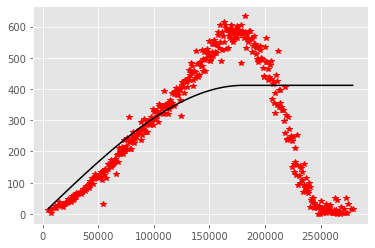

In [103]:
OK = OrdinaryKriging(x,y,cu, variogram_model='spherical', nlags=450, 
                    enable_plotting=True, 
                    coordinates_type='euclidean')

#Ajuste del variograma experimental con un modelo esférico, 20 pasos, una meseta de 0.22 (lo cual es la varianza de los datos)
#, alcance de 175 metros y sin efecto pepita.

In [104]:
x_min=x.min()
x_max=x.max()
y_min=y.min()
y_max=y.max()
grid_x = np.linspace(x_min, x_max, num=450, endpoint=False) #Se crean 46 celdas de 10 metros desde min() - max() del eje X.
grid_y = np.linspace(y_min, y_max, num=450, endpoint=False) #Se crean 41 celdas de 10 metros desde min() - max() del eje Y.

In [105]:
z, ss = OK.execute('grid', grid_x, grid_y) # z es la ley de cobre y ss la varianza

In [106]:
kt.write_asc_grid(grid_x, grid_y, z, filename="kriging_ordinario.asc") #Kriging Ordinario en forma de matriz

In [107]:
kt.write_asc_grid(grid_x, grid_y, ss, filename="kriging_ordinario_var.asc") #Varianza de estimación en forma de matriz

In [108]:
asc = pd.read_csv("kriging_ordinario.asc", header=None, skiprows=7, sep="\s+") 
asc.shape #comprobar que sean 41 filas y 46 columnas

(450, 450)

In [109]:
cu2 = np.array(asc) #Conversión pandas dataframe a ndarray
cu2

array([[209.86, 209.85, 209.84, ..., 223.6 , 223.58, 223.56],
       [209.88, 209.87, 209.86, ..., 223.71, 223.69, 223.66],
       [209.91, 209.9 , 209.89, ..., 223.81, 223.79, 223.77],
       ...,
       [205.64, 205.61, 205.6 , ..., 194.2 , 194.19, 194.18],
       [205.69, 205.67, 205.65, ..., 194.12, 194.11, 194.1 ],
       [205.75, 205.73, 205.71, ..., 194.04, 194.03, 194.02]])

([], <a list of 0 Text yticklabel objects>)

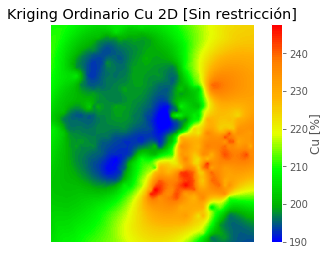

In [110]:
#fig = plt.figure(figsize=(17,15))

#plot1 = fig.add_subplot(131)
a = plt.imshow(cu2,extent=[x_min,x_max,y_min,y_max], cmap=cm, vmin=190) #gist_rainbow
plt.grid(False)

cbar = plt.colorbar()
cbar.set_label("Cu [%]", labelpad=+1)

plt.title('Kriging Ordinario Cu 2D [Sin restricción]')
marker_size = 1
#plt.scatter(x, y, marker_size, cu)
#plt.axis('equal')
plt.xticks([])
plt.yticks([])